# Kubernetes cluster configuration

First, you need to bootstrap some dependencies such as `kubectl`, `helm`.

[Here](bootstrap.ipynb) are some quick commands to help you.

In [87]:
export PATH=`pwd`:$PATH
which kubectl helm

/home/pierre/workspace/articles/k8s_201/kubectl
/home/pierre/workspace/articles/k8s_201/helm


### Check your cluster config

Fetch your kube config file from the OVH Manager and save it in your local folder.

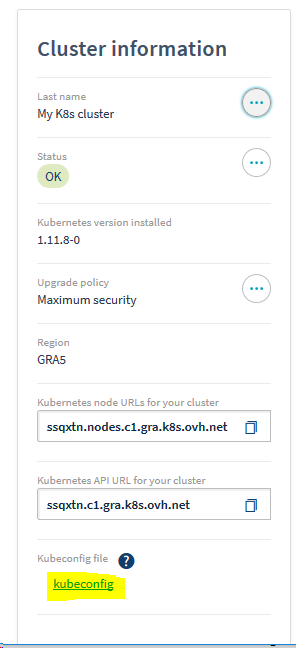

Next, set the `KUBECONFIG` environment variable.



In [57]:
export KUBECONFIG=`pwd`/kubeconfig.yaml

and check that you can access your cluster

In [58]:
kubectl cluster-info

Kubernetes master is running at https://ssqxtn.c1.gra.k8s.ovh.net
KubeDNS is running at https://ssqxtn.c1.gra.k8s.ovh.net/api/v1/namespaces/kube-system/services/kube-dns:dns/proxy

To further debug and diagnose cluster problems, use 'kubectl cluster-info dump'.


Check that you can connect and you have at least one node available

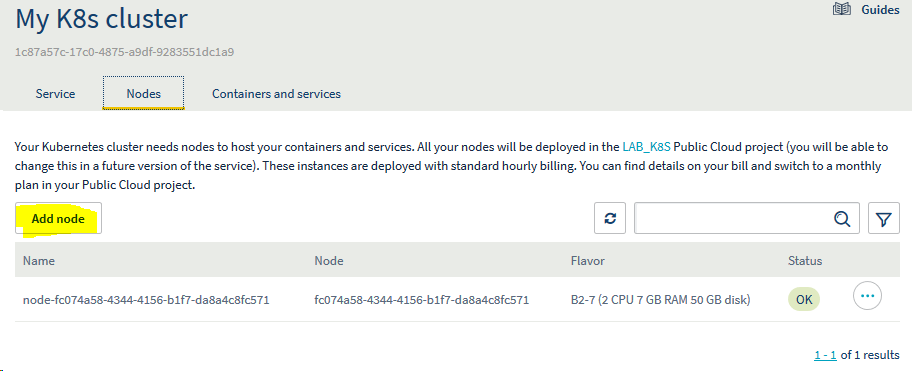

In [59]:
kubectl get nodes

NAME                                        STATUS   ROLES    AGE   VERSION
node-fc074a58-4344-4156-b1f7-da8a4c8fc571   Ready    <none>   22d   v1.11.7


## Helm/Tiller

Next, to simplify our deployement, we'll use helm.

[Helm](https://github.com/helm/helm) is a tool for managing packages of pre-configured Kubernetes resources known as _charts_.

It has two componenents:

- a local client `helm` to [install](https://helm.sh/docs/using_helm/#install-helm) in your local environment.
- a Kubernetes service `tiller`.

### Configure RBAC for Tiller

To allow tiller to manager the chars, we need first to create a `ServiceAccount` and give it `cluster-admin` rights.

The full doc is available [here](https://docs.gitlab.com/ee/install/kubernetes/preparation/tiller.html)


In [93]:
cat > config.yml <<EOF
apiVersion: v1
kind: ServiceAccount
metadata:
  name: tiller
  namespace: kube-system
---
apiVersion: rbac.authorization.k8s.io/v1
kind: ClusterRoleBinding
metadata:
  name: tiller
roleRef:
  apiGroup: rbac.authorization.k8s.io
  kind: ClusterRole
  name: cluster-admin
subjects:
  - kind: ServiceAccount
    name: tiller
    namespace: kube-system
EOF

In [94]:
kubectl create -f config.yml # apply config

Error from server (AlreadyExists): error when creating "config.yml": serviceaccounts "tiller" already exists
Error from server (AlreadyExists): error when creating "config.yml": clusterrolebindings.rbac.authorization.k8s.io "tiller" already exists


: 1

### Init helm

Use the `--upgrade` if tiller is already installed.


In [89]:
helm init --upgrade --service-account tiller

$HELM_HOME has been configured at /home/pierre/.helm.

Tiller (the Helm server-side component) has been upgraded to the current version.
Happy Helming!


In [95]:
kubectl get pods -n kube-system -l app=helm # check that the pod is up and running

NAME                             READY   STATUS    RESTARTS   AGE
tiller-deploy-57c574bfb8-t4zf7   1/1     Running   0          2h


In [96]:
helm version # check that both client and server version are the same

Client: &version.Version{SemVer:"v2.13.0", GitCommit:"79d07943b03aea2b76c12644b4b54733bc5958d6", GitTreeState:"clean"}
Server: &version.Version{SemVer:"v2.13.0", GitCommit:"79d07943b03aea2b76c12644b4b54733bc5958d6", GitTreeState:"clean"}


In [92]:
helm repo update # Update the helm package list

Hang tight while we grab the latest from your chart repositories...
...Skip local chart repository
...Successfully got an update from the "elastic" chart repository
...Successfully got an update from the "stable" chart repository
Update Complete. ⎈ Happy Helming!⎈ 


# Install MongoDB

The chart documetation is available [here](https://github.com/helm/charts/tree/master/stable/mongodb)

First, we will delete any existing MongoDB deployement and then deploy a new one.

In [65]:
kubectl delete all --selector=app=mongodb

pod "tan-toucan-mongodb-b7c7dd8b9-vxkd8" deleted
service "tan-toucan-mongodb" deleted
deployment.apps "tan-toucan-mongodb" deleted
replicaset.apps "tan-toucan-mongodb-b7c7dd8b9" deleted


In [66]:
helm install --name my-mongodb stable/mongodb

NAME:   my-mongodb
LAST DEPLOYED: Tue Mar 12 17:38:57 2019
NAMESPACE: default
STATUS: DEPLOYED

RESOURCES:
==> v1/Secret
NAME        TYPE    DATA  AGE
my-mongodb  Opaque  1     0s

==> v1/PersistentVolumeClaim
NAME        STATUS   VOLUME             CAPACITY  ACCESS MODES  STORAGECLASS  AGE
my-mongodb  Pending  cinder-high-speed  0s

==> v1/Service
NAME        TYPE       CLUSTER-IP  EXTERNAL-IP  PORT(S)    AGE
my-mongodb  ClusterIP  10.3.60.11  <none>       27017/TCP  0s

==> v1beta1/Deployment
NAME        DESIRED  CURRENT  UP-TO-DATE  AVAILABLE  AGE
my-mongodb  1        1        1           0          0s

==> v1/Pod(related)
NAME                        READY  STATUS   RESTARTS  AGE
my-mongodb-dc4f8dd66-4k6x2  0/1    Pending  0         0s


NOTES:


** Please be patient while the chart is being deployed **

MongoDB can be accessed via port 27017 on the following DNS name from within your cluster:

    my-mongodb.default.svc.cluster.local

To get the root password run:

    export MONGO

Check that the pod is up and running

In [101]:
kubectl get pods --namespace=default -l app=mongodb -o wide

NAME                         READY   STATUS    RESTARTS   AGE   IP         NODE     NOMINATED NODE
my-mongodb-dc4f8dd66-wdntf   1/1     Running   0          8h    10.2.2.9   b2-7.1   <none>


# Install ElasticSearch

The chart documetation is available [here](https://github.com/elastic/helm-charts/tree/master/elasticsearch)

ElasticSearch will require to have at least 3 nodes available.

First, we need to install ElasticSearch helm repository

In [70]:
helm repo add elastic https://helm.elastic.co

"elastic" has been added to your repositories


In [69]:
helm install --name my-elasticsearch elastic/elasticsearch --set volumeClaimTemplate.storageClassName=cinder-high-speed

NAME:   my-elasticsearch
LAST DEPLOYED: Tue Mar 12 17:40:32 2019
NAMESPACE: default
STATUS: DEPLOYED

RESOURCES:
==> v1beta1/PodDisruptionBudget
NAME                      MIN AVAILABLE  MAX UNAVAILABLE  ALLOWED DISRUPTIONS  AGE
elasticsearch-master-pdb  N/A            1                0                    1s

==> v1/Service
NAME                           TYPE       CLUSTER-IP    EXTERNAL-IP  PORT(S)            AGE
elasticsearch-master           ClusterIP  10.3.107.154  <none>       9200/TCP,9300/TCP  0s
elasticsearch-master-headless  ClusterIP  None          <none>       9200/TCP           0s

==> v1beta1/StatefulSet
NAME                  DESIRED  CURRENT  AGE
elasticsearch-master  3        3        0s

==> v1/Pod(related)
NAME                    READY  STATUS   RESTARTS  AGE
elasticsearch-master-0  0/1    Pending  0         0s
elasticsearch-master-1  0/1    Pending  0         0s
elasticsearch-master-2  0/1    Pending  0         0s


NOTES:
1. Watch all cluster members come up.
  $ kub

Check that the pods are up and running

In [100]:
kubectl get pods --namespace=default -l app=elasticsearch-master -o wide

NAME                     READY   STATUS    RESTARTS   AGE   IP         NODE     NOMINATED NODE
elasticsearch-master-0   1/1     Running   0          5h    10.2.4.2   b2-7.3   <none>
elasticsearch-master-1   1/1     Running   0          5h    10.2.3.2   b2-7.2   <none>
elasticsearch-master-2   1/1     Running   0          20h   10.2.2.2   b2-7.1   <none>


From this step, you should have working ElasticSearch and MongoDB services.

Let's move to Gravitee.io.

# Install Gravitee.io

[gravitee.io](https://gravitee.io/) is an api manager. It could be seen as an [`IngressController`](https://kubernetes.io/docs/concepts/services-networking/ingress/)but with a developper point of view.

The setup is described [here](gravitee-setup.ipynb)